# imports

In [33]:
# ==========================
# 1. 標準庫
# ==========================
import sys
import os
import io
import json
import glob
import datetime
import random
from pathlib import Path
from typing import Dict, List, Union, Callable, Optional, Tuple

# ==========================
# 2. 第三方套件
# ==========================
import numpy as np
import xarray as xr
import matplotlib.pylab as plt
from tqdm import trange
from IPython.display import clear_output, display, HTML
from scipy.ndimage import generic_filter

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as Optimizer
from torchsummary import summary

# import cv2  # 如果影片相關再啟用

# ==========================
# 3. 專案設定
# ==========================
project_root = "C:/Users/GAI/Desktop/Scott/NCA_Research"
if project_root not in sys.path:
    sys.path.append(project_root)

# ==========================
# 4. IPython 魔法指令 (Jupyter 專用)
# ==========================
%reload_ext autoreload
%autoreload 2

# ==========================
# 5. 專案自定義函式庫
# ==========================
from core_utils.plotting import (
    plt_HWC_split_channels,
    plt_CFD_channels,
    plt_random_cfd_slice
)


# from core_utils.utils_io import (
#     np2pil,      # numpy → PIL Image
#     imwrite,     # 儲存圖像為檔案
#     imencode,    # 編碼圖像為 byte stream
#     im2url,      # 圖像轉 base64 URL（HTML 顯示用）
#     load_emoji,   # 載入 emoji 圖像
#     load_cfd_npy
# )

# from core_utils.utils_image import (
#     imshow,      # 在 notebook 顯示圖像
#     tile2d,      # 多圖拼接
#     zoom         # 放大圖像
# )

# from core_utils.utils_video import (
#     save_video,  # 批次輸出影片
#     VideoWriter  # 逐幀寫入影片（支援 context manager）
# )

# from core_utils.ops_tf_np import (
#     to_rgb,
#     to_rgba,
#     to_alpha,
#     crop_and_resize,
#     get_random_cfd_slices,
#     get_random_cfd_slices_pair
# )


from core_utils.viz_train import (
    viz_pool,
    viz_batch,
    viz_loss
)


# 6. 實驗項目 utils 函式庫導入
from E4_PI_NCA.utils.helper import (
    to_HWC,
    print_tensor_stats,
    split_cases,
    norm_CHW,
    norm_CHW_select


)

clear_output()

# process urbantales cases into npz file 

In [34]:
def nan_to_masked_CHW(CHW: np.ndarray) -> np.ndarray:
    """
    將 CHW 張量中的 NaN 補 0，並在 channel 維度上加一個 mask (C+1, H, W)
    Mask: 原本是 NaN 的位置為 0，其他位置為 1

    Parameters
    ----------
    CHW : np.ndarray
        shape = (C, H, W)

    Returns
    -------
    masked_CHW : np.ndarray
        shape = (C+1, H, W), 最後一個 channel 為 mask
    """
    # 生成 mask (原本非 NaN = 1, NaN = 0)
    mask = (~np.isnan(CHW)).astype(np.float32)
    # mask = mask[:, ::-1,:]

    # 補 0
    CHW_clean = np.nan_to_num(CHW, nan=0)

    # concat mask
    masked_CHW = np.concatenate([mask.mean(axis=0, keepdims=True), CHW_clean], axis=0)
    return masked_CHW

In [35]:
from pathlib import Path
import numpy as np
import xarray as xr
import torch
import torch.nn.functional as F

# =========================================
# 設定資料夾路徑
# =========================================
folder = Path("../dataset")

# 存放每個 case 的資料與 channel 名稱
case_dict = {}
channel_name_dict = {}

# =========================================
# 遍歷所有 ped.nc 檔案
# =========================================
for ped_file in folder.rglob("*ped.nc"):
    case_name = ped_file.parent.name  # case 名稱 = 資料夾名稱

    # -----------------------------------------
    # 解析風向 (從資料夾名稱抓 _d 後的數字)
    # -----------------------------------------
    wind_direction = case_name.split("_d")[-1]
    wind_direction = np.array(wind_direction, dtype=float)

    # -----------------------------------------
    # 讀取 NetCDF 檔案
    # -----------------------------------------
    with xr.open_dataset(ped_file) as ds:
        # 把所有變數堆疊成 (H, W, C)
        arrays = [ds[var].values for var in ds.data_vars]
        ped_np = np.stack(arrays, axis=-1)

        # 初始化風向 (兩個 channel: x, y)
        wind_np = np.zeros_like(ped_np[..., 0:2])
        wind_np[..., 0:1] = np.sin(np.deg2rad(wind_direction))  # windInitX
        wind_np[..., 1:2] = np.cos(np.deg2rad(wind_direction))  # windInitY

        # channel 名稱 (從 NetCDF 的變數名稱)
        channel_names = list(ds.data_vars.keys())

    # -----------------------------------------
    # 對應 topo 檔案
    # -----------------------------------------
    topo_file = ped_file.parent.glob("*_topo")
    topo_file = next(topo_file, None)

    if topo_file:
        topo = np.loadtxt(topo_file)[:, :, np.newaxis]  # (H, W, 1)
        # 合併成 (H, W, C)，順序 = topo + windInit + 原始 ped
        ped_np = np.concatenate([topo[::-1, :, :], wind_np, ped_np], axis=2)

        # 插入對應的 channel 名稱
        channel_names.insert(0, "topo")
        channel_names.insert(1, "windInitX")
        channel_names.insert(2, "windInitY")

    # -----------------------------------------
    # 後處理
    # -----------------------------------------
    # (H, W, C) -> (C, H, W)
    ped_np = np.transpose(ped_np, (2, 0, 1))

    # 處理 NaN 並加上 mask (C+1, H, W)
    ped_np = nan_to_masked_CHW(ped_np)

    # 轉成 torch tensor 並 resize 到 (96, 96)
    ped_np = torch.from_numpy(ped_np).unsqueeze(dim=0)  # (1, C, H, W)
    ped_np = F.interpolate(
        ped_np, size=(96, 96), mode='bilinear', align_corners=False
    ).detach().cpu().numpy().squeeze()  # (C, 96, 96)

    # Channel-wise normalization (僅選特定 channel)
    ped_np = norm_CHW_select(ped_np, channels=[1])

    # 把 geo_mask 放到 channel_names 開頭
    channel_names.insert(0, "geo_mask")

    # 存入 dict
    case_dict[case_name] = ped_np
    channel_name_dict[case_name] = channel_names

# =========================================
# 將所有 case 存成壓縮檔
# =========================================
np.savez_compressed("../dataset/all_cases.npz", **case_dict)

# 簡單驗證
print("所有 case 已存成 all_cases.npz")
example_case = next(iter(case_dict))
print("範例 case shape:", case_dict[example_case].shape)
print("範例 case channel names:", channel_name_dict[example_case])
print("所有 case keys:", case_dict.keys())


所有 case 已存成 all_cases.npz
範例 case shape: (9, 96, 96)
範例 case channel names: ['geo_mask', 'topo', 'windInitX', 'windInitY', 'uped', 'vped', 'Uped', 'TKEped', 'Tuwped']
所有 case keys: dict_keys(['FR-PA-V1_d00', 'FR-PA-V2_d00', 'FR-PA-V2_d15', 'FR-PA-V2_d30', 'FR-PA-V2_d45', 'FR-PA-V2_d90'])


'uped', 'vped' vel_ped 平均風速(不包含湍流) Uped 平均風速(包含湍流)  TKEped(湍流項)



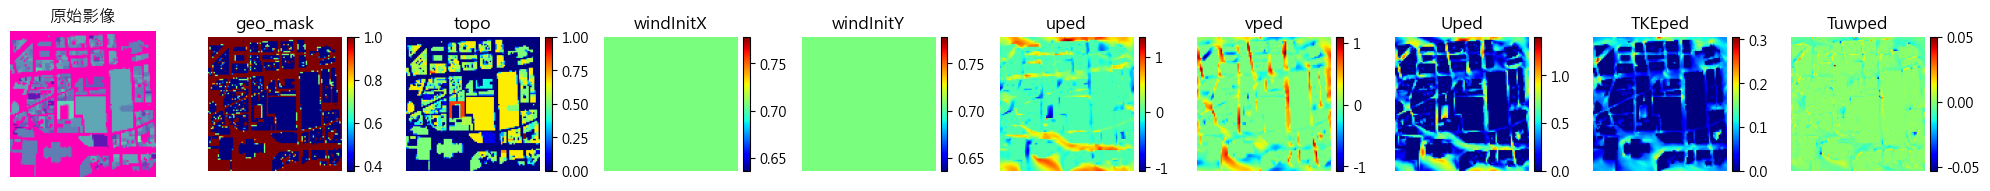

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.068086..2.068086].


FR-PA-V2_d45 (C,H,W) shape = (9, 96, 96)
  channel 0: min=0.375000, max=1.000000
  channel 1: min=0.000000, max=1.000000
  channel 2: min=0.707107, max=0.707107
  channel 3: min=0.707107, max=0.707107
  channel 4: min=-1.068086, max=1.362007
  channel 5: min=-1.073087, max=1.099888
  channel 6: min=0.000000, max=1.402120
  channel 7: min=0.000000, max=0.305751
  channel 8: min=-0.053437, max=0.050170
Has NaN: False
Has Inf: False


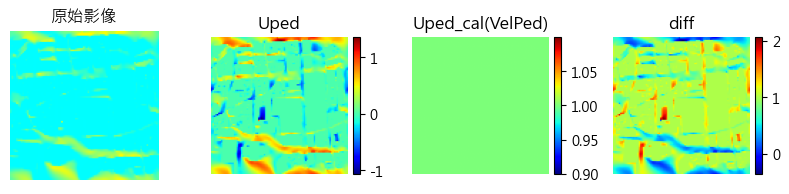

vis_data (C,H,W) shape = (3, 96, 96)
  channel 0: min=-1.068086, max=1.362007
  channel 1: min=1.000000, max=1.000000
  channel 2: min=-0.362007, max=2.068086
MAE  = 0.925561
MSE  = 0.920452
RMSE = 0.959402


In [36]:
channel_names = ["geo_mask", "topo", 'windInitX', 'windInitY',"uped", "vped", "Uped", "TKEped", "Tuwped"]
# 將 keys 轉成 list，再隨機選一個
for _ in range(1):
    print("\n")
    key = random.choice(list(case_dict.keys()))
    case = case_dict[key]
    plt_HWC_split_channels(to_HWC(case), channel_names=channel_names)
    print_tensor_stats(case, name=key)

    print("Has NaN:", np.isnan(to_HWC(case)).any())
    print("Has Inf:", np.isinf(to_HWC(case)).any())

    # 計算 Uped_cal
    Uped_cal = np.sqrt(case[2] ** 2 + case[3] ** 2)  # (H,W)
    Uped_cal = np.expand_dims(Uped_cal, axis=0)  # (1,H,W)

    # 真值 vs 計算值差異
    Uped_true = case[4:5]  # (1,H,W)
    Uped_diff = Uped_cal - Uped_true  # (1,H,W)

    # --- 視覺化堆疊 ---
    vis_data = np.concatenate([Uped_true, Uped_cal, Uped_diff], axis=0)  # (3,H,W)
    # vis_data = norm_CHW(vis_data)
    plt_HWC_split_channels(
        to_HWC(vis_data), channel_names=["Uped", "Uped_cal(VelPed)", "diff"]
    )
    print_tensor_stats(vis_data, name="vis_data")

    # --- 誤差指標 ---
    mae = np.nanmean(np.abs(Uped_diff))
    mse = np.nanmean(Uped_diff**2)
    rmse = np.sqrt(mse)

    print(f"MAE  = {mae:.6f}")
    print(f"MSE  = {mse:.6f}")
    print(f"RMSE = {rmse:.6f}")

diff (C,H,W) shape = (3, 576, 576)
  channel 0: min=0.000000, max=1.000000
  channel 1: min=0.132037, max=1.213971
  channel 2: min=-0.387055, max=0.724844
MAE  = 0.311444
MSE  = 0.184001
RMSE = 0.428954

diff (C,H,W) shape = (3, 576, 576)
  channel 0: min=0.000000, max=1.000000
  channel 1: min=0.000000, max=1.000000
  channel 2: min=0.000000, max=1.000000
MAE  = 0.292664
MSE  = 0.142941
RMSE = 0.378075



(9, 96, 96)
fft_result torch.Size([9, 96, 96]) <built-in method type of Tensor object at 0x000001D4168A7230>
tensor(9.7983e-10)
tensor(-1.4822e-09)
tensor(0.)
tensor(0.)
tensor(-2.2904e-09)
tensor(1.3850e-09)
tensor(9.4953e-09)
tensor(6.4838e-10)
tensor(8.1734e-12)


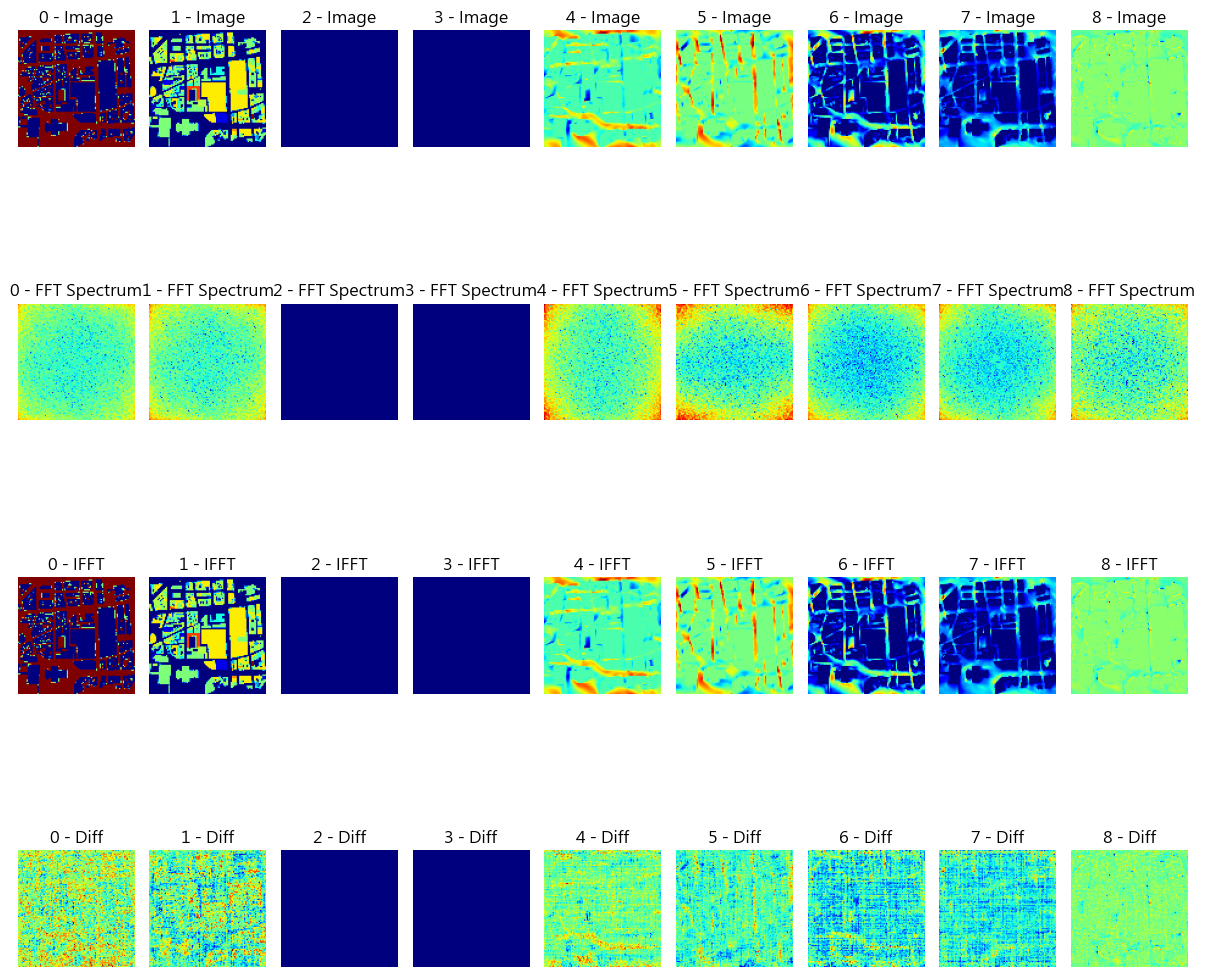

fft_result torch.Size([9, 96, 96]) <built-in method type of Tensor object at 0x000001D417E684D0>
tensor(9.7983e-10)
tensor(-1.4822e-09)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(0.)


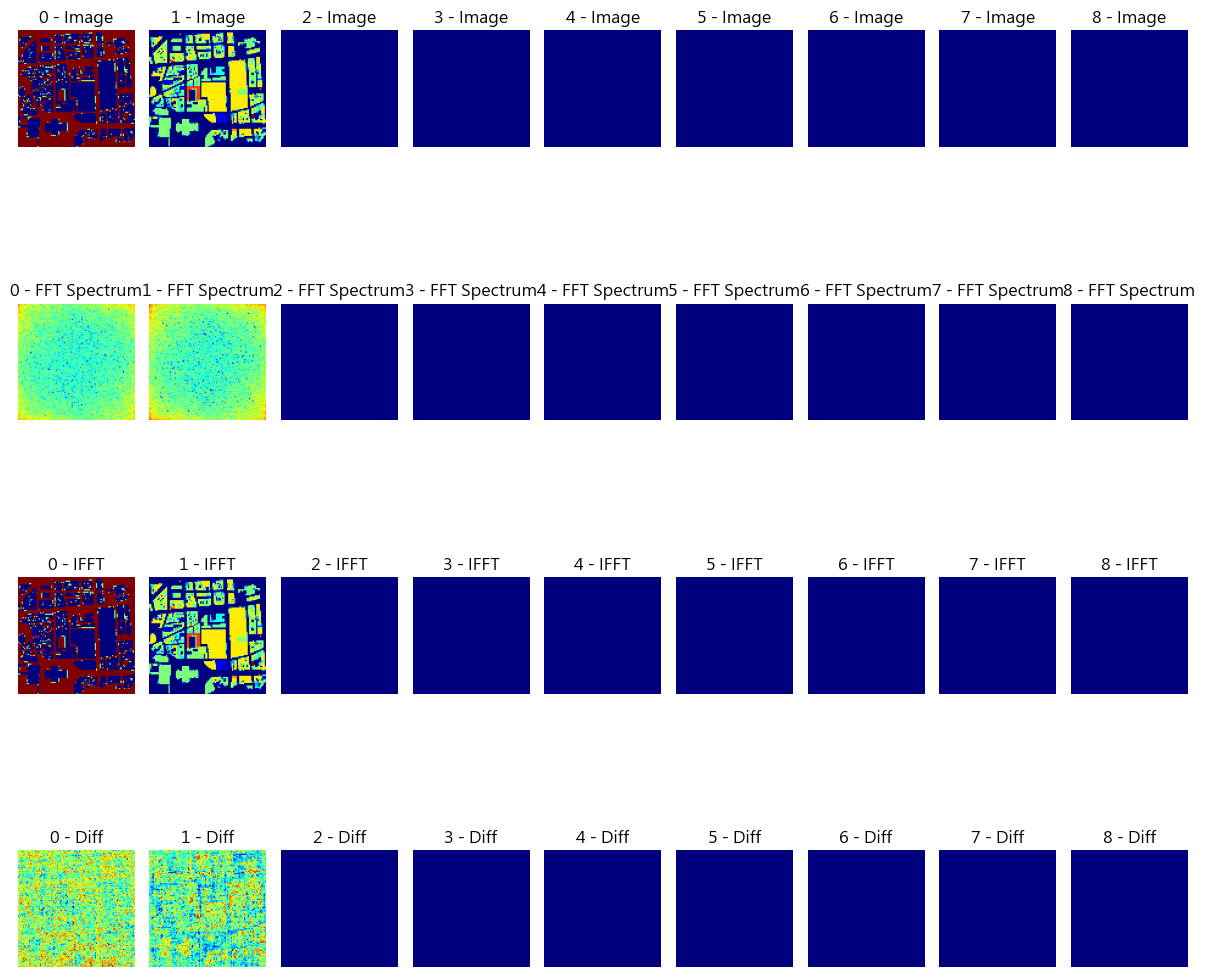

In [37]:
def plt_fft_img(img):
    img = torch.from_numpy(img)

    # ====== FFT ======
    fft_result = torch.fft.fft2(img)
    print("fft_result",fft_result.shape, fft_result.type)
    # fft_shifted = torch.fft.fftshift(fft_result, dim=(-2, -1))
    magnitude_spectrum = torch.log(torch.abs(fft_result) + 1e-8)

    # ====== IFFT ======
    ifft_result = torch.fft.ifft2(fft_result)
    ifft_real = ifft_result.real

    # ====== 差異 ======
    diff = img - ifft_real
    mse_per_channel = torch.mean(diff ** 2, dim=(-2, -1))  # 每個 channel 的 MSE
    # ====== 畫圖 ======
    fig, axes = plt.subplots(4, img.shape[0], figsize=(12, 12))

    for c in range(img.shape[0]):
        # 原圖 channel
        axes[0, c].imshow(img[c].cpu().numpy(), cmap="jet")
        axes[0, c].set_title(f"{c} - Image")
        axes[0, c].axis("off")

        # FFT 頻譜 channel
        axes[1, c].imshow(magnitude_spectrum[c].cpu().numpy(), cmap="jet")
        axes[1, c].set_title(f"{c} - FFT Spectrum")
        axes[1, c].axis("off")

        # IFFT 還原 channel
        axes[2, c].imshow(ifft_real[c].cpu().numpy(), cmap="jet")
        axes[2, c].set_title(f"{c} - IFFT")
        axes[2, c].axis("off")

        # 原始 - 還原差異
        axes[3, c].imshow(diff[c].cpu().numpy(), cmap="jet")
        axes[3, c].set_title(f"{c} - Diff")
        axes[3, c].axis("off")
        print(torch.mean(diff[c]))

    plt.tight_layout()
    plt.show()

for _ in range(1):
    print("\n")
    key = random.choice(list(case_dict.keys()))
    img = case_dict[key]
    print(img.shape)
    plt_fft_img(img)
    img[2:,:,:] = 0
    plt_fft_img(img)
    # img = img.astype(np.float64) 





(9, 96, 96)
Iteration 1/100, MSE=4.528e-33
Iteration 21/100, MSE=3.737e-31
Iteration 41/100, MSE=1.224e-30
Iteration 61/100, MSE=2.528e-30
Iteration 81/100, MSE=4.334e-30


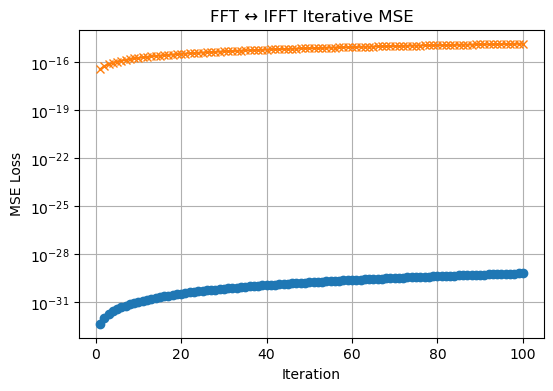

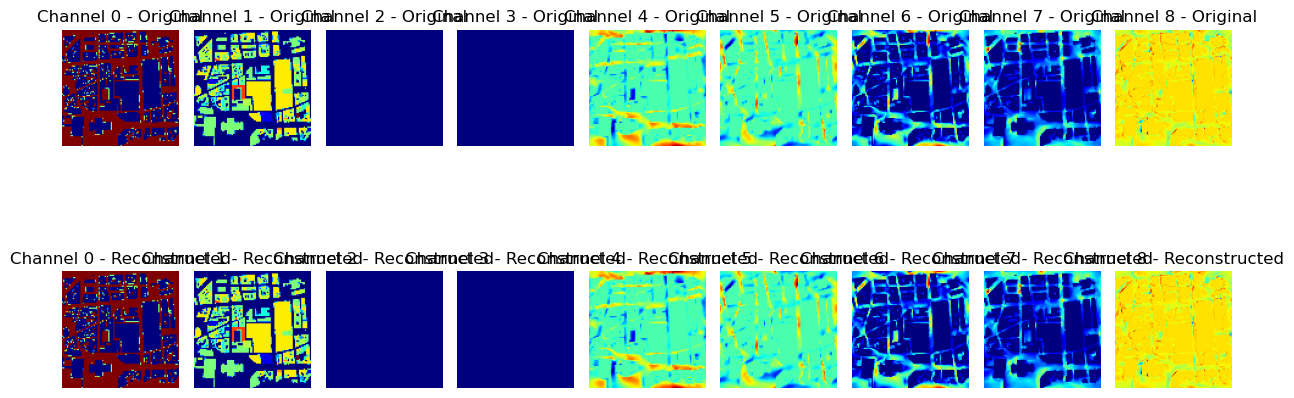

In [38]:
plt.rcParams['font.family'] = 'DejaVu Sans'  # 支援大部分 Unicode


def fft_ifft_iterations(img: torch.Tensor, n_iter: int = 5):
    """
    img: CHW tensor (float32 或 float64)
    n_iter: 迭代次數
    """
    # 確保是 float64 精度
    img = img.double()
    C, H, W = img.shape
    mse_list = []
    mae_list = []

    # 初始化還原圖
    recon = img.clone()

    for i in range(n_iter):
        # FFT + IFFT
        fft_result = torch.fft.fft2(recon)
        recon = torch.fft.ifft2(fft_result).real

        # 計算差異
        diff = img - recon
        mse = torch.mean(diff**2).item()
        mae = torch.mean(torch.abs(diff)).item()
        mse_list.append(mse)
        mae_list.append(mae)
        if i%20==0:
            print(f"Iteration {i+1}/{n_iter}, MSE={mse:.3e}")

    # Plot MSE Loss
    plt.figure(figsize=(6,4))
    plt.plot(range(1, n_iter+1), mse_list, marker='o')
    plt.plot(range(1, n_iter+1), mae_list, marker='x', label="MAE")
    plt.xlabel("Iteration")
    plt.ylabel("MSE Loss")
    plt.title("FFT ↔ IFFT Iterative MSE")
    plt.yscale("log")
    plt.grid(True)
    plt.show()

    # Plot 原圖 vs 最後還原圖 (每個 channel)
    fig, axes = plt.subplots(2, C, figsize=(12, 6))
    for c in range(C):
        axes[0, c].imshow(img[c].cpu().numpy(), cmap="jet")
        axes[0, c].set_title(f"Channel {c} - Original")
        axes[0, c].axis("off")

        axes[1, c].imshow(recon[c].cpu().numpy(), cmap="jet")
        axes[1, c].set_title(f"Channel {c} - Reconstructed")
        axes[1, c].axis("off")

    plt.tight_layout()
    plt.show()

    return recon, mse_list, mae_list

for _ in range(1):
    print("\n")
    key = random.choice(list(case_dict.keys()))
    img = case_dict[key]
    print(img.shape)
    # img = img.astype(np.float64) 
    img = torch.from_numpy(img)
    recon, mse_list, mae_list = fft_ifft_iterations(img, n_iter=100)

In [39]:

# 假設 img 是 torch.Tensor, shape = [C, H, W]
# 範例：隨機影像 (3通道)
img = torch.rand(3, 128, 128)


